In [2]:
from folktables import ACSDataSource, ACSIncome
import deferred_acceptance as da

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import itertools

In [237]:
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['custom_style.mplstyle'])
helvetica_bold = Path(matplotlib.get_data_path(), "/Users/kennypeng/Downloads/helvetica/Helvetica-Bold-02.ttf")
plt.rcParams.update(matplotlib.rcParamsDefault)


Bad key axes.titlefont in file custom_style.mplstyle, line 2 ('axes.titlefont: helvetica_bold')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.3/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


# ACSIncome California 2018

In [374]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(acs_data)
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.1, random_state=0)

In [375]:
print('Number of applicants:', len(y_test))
print('Number of applicants with positive label:', np.sum(y_test))

Number of applicants: 19567
Number of applicants with positive label: 7933


In [376]:
# For each pair of features, train an ML model using those features and evaluate the associated monoculture market

C = 5
college_caps = [1000 for _ in range(C)]
N = len(y_test)

monoculture_accs = []
monoculture_ranks = []
indices_subset = []
for i, indices in enumerate(itertools.combinations(range(10), 2)):
    approximate_values = []
    for indices in [indices, indices, indices, indices, indices]:

        model = make_pipeline(StandardScaler(), LogisticRegression())
        model.fit(X_train[:,indices], y_train)

        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])

    student_values = [np.random.uniform(size=C) for _ in range(N)]
    student_prefs = da.prefs_from_values(student_values)
    college_prefs = da.prefs_from_values(approximate_values)
    student_matches, college_matches = da.get_match(student_prefs, college_prefs, college_caps)

    acc = np.mean([y_test[i] for i in np.array(college_matches).flatten()])
    monoculture_accs.append(acc)
    monoculture_ranks.append(np.sum(da.student_rank_of_match(student_prefs, student_matches))/5000)

In [377]:
# Get 20 models with most accurate monoculture matchings
indices_subset = []
indices_subset_args = []
indices_subset_args = np.argsort(-np.array(monoculture_accs))[:20]
indices_subset = [list(itertools.combinations(range(10), 2))[i] for i in indices_subset_args]

In [378]:
# get 50 random subsets of 5 models with accuracies within 0.05

from random import sample
import random
random.seed(0)
indices_candidates = []
for indices_candidate in sample(list(itertools.combinations(indices_subset_args, 5), ), 1000):
    candidate_accs = [monoculture_accs[indices_candidate[i]] for i in range(5)]
    if np.max(candidate_accs) - np.min(candidate_accs) < 0.05:
        indices_candidates.append(indices_candidate)
        print(np.min(candidate_accs), np.max(candidate_accs))
indices_candidates = sample(indices_candidates, 50)


0.673 0.6996
0.6622 0.7108
0.6662 0.7074
0.6938 0.7316
0.6662 0.7036
0.689 0.7108
0.693 0.7108
0.7108 0.751
0.6662 0.7074
0.6518 0.6996
0.6938 0.7254
0.6622 0.6996
0.673 0.722
0.6938 0.7316
0.6662 0.6996
0.673 0.7036
0.6662 0.7108
0.6662 0.7108
0.6622 0.7108
0.693 0.7108
0.6938 0.7316
0.688 0.722
0.6662 0.6996
0.6938 0.7254
0.693 0.7316
0.688 0.7316
0.6996 0.7422
0.6996 0.7316
0.6662 0.7108
0.6662 0.7036
0.688 0.7316
0.673 0.722
0.688 0.7316
0.6662 0.6996
0.689 0.7254
0.673 0.7074
0.689 0.7108
0.6622 0.7074
0.6622 0.7108
0.689 0.7254
0.6662 0.7074
0.688 0.7316
0.722 0.7654
0.688 0.7108
0.722 0.7654
0.689 0.7254
0.6938 0.7422
0.6622 0.7074
0.6938 0.7254
0.6662 0.7036
0.673 0.7108
0.6662 0.7074
0.6996 0.7422
0.688 0.7074
0.689 0.7316
0.693 0.7422
0.6622 0.6996
0.673 0.7108
0.6622 0.7108
0.6622 0.7036
0.688 0.7108
0.693 0.7422
0.673 0.722
0.6662 0.7108
0.6662 0.7108
0.6996 0.7254
0.688 0.7316
0.6996 0.7422
0.693 0.7422
0.6938 0.7254
0.6622 0.7074
0.6662 0.7108
0.673 0.6996
0.6662 0.7036
0

In [339]:
# evaluate polyculture markets

C = 5
college_caps = [1000 for _ in range(C)]
N = len(y_test)

accs_ca = []
ranks_ca = []

for indices_list in indices_candidates:
    sub_accs = []
    sub_ranks = []
    print(indices_list)
    approximate_values = []
    for i in indices_list:
        indices = list(itertools.combinations(range(10), 2))[i]

        model = make_pipeline(StandardScaler(), LogisticRegression())
        model.fit(X_train[:,indices], y_train)

        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])

    student_values = [np.random.uniform(size=C) for _ in range(N)]
    student_prefs = da.prefs_from_values(student_values)
    college_prefs = da.prefs_from_values(approximate_values)
    student_matches, college_matches = da.get_match(student_prefs, college_prefs, college_caps)

    acc = np.mean([y_test[i] for i in np.array(college_matches).flatten()])
    sub_accs.append(acc)
    sub_ranks.append(np.sum(da.student_rank_of_match(student_prefs, student_matches))/5000)

    for i in range(5):
        acc = monoculture_accs[indices_list[i]]
        sub_accs.append(acc)
        sub_ranks.append(monoculture_ranks[indices_list[i]])

    ranks_ca.append(sub_ranks)
    accs_ca.append(sub_accs)
    print()



(30, 34, 33, 1, 39)

(31, 17, 3, 33, 22)

(31, 11, 30, 3, 33)

(24, 11, 30, 34, 9)

(3, 33, 9, 19, 39)

(24, 30, 23, 22, 9)

(17, 30, 33, 1, 39)

(34, 33, 19, 39, 6)

(18, 31, 24, 17, 34)

(32, 18, 31, 24, 11)

(31, 24, 30, 34, 33)

(18, 20, 11, 17, 3)

(11, 17, 34, 19, 39)

(17, 30, 3, 22, 1)

(20, 24, 17, 34, 23)

(20, 34, 33, 22, 1)

(32, 18, 20, 31, 11)

(18, 20, 11, 30, 34)

(22, 9, 19, 39, 6)

(17, 33, 22, 9, 39)

(11, 30, 3, 23, 1)

(34, 3, 1, 19, 39)

(31, 24, 11, 30, 33)

(20, 31, 11, 34, 33)

(17, 30, 23, 1, 9)

(34, 33, 23, 22, 19)

(11, 17, 33, 9, 19)

(20, 31, 30, 34, 3)

(20, 31, 24, 30, 33)

(11, 17, 30, 33, 23)

(23, 22, 1, 9, 39)

(11, 3, 23, 1, 9)

(17, 30, 3, 1, 19)

(24, 17, 33, 1, 9)

(11, 23, 22, 19, 39)

(18, 34, 3, 33, 23)

(3, 22, 1, 9, 19)

(11, 33, 23, 19, 39)

(11, 17, 22, 1, 39)

(11, 30, 34, 3, 1)

(20, 11, 30, 3, 1)

(11, 34, 3, 19, 39)

(31, 11, 17, 30, 22)

(30, 3, 22, 9, 39)

(30, 34, 23, 22, 9)

(18, 20, 31, 34, 23)

(22, 1, 19, 39, 27)

(23, 9, 19, 3

## Accuracy

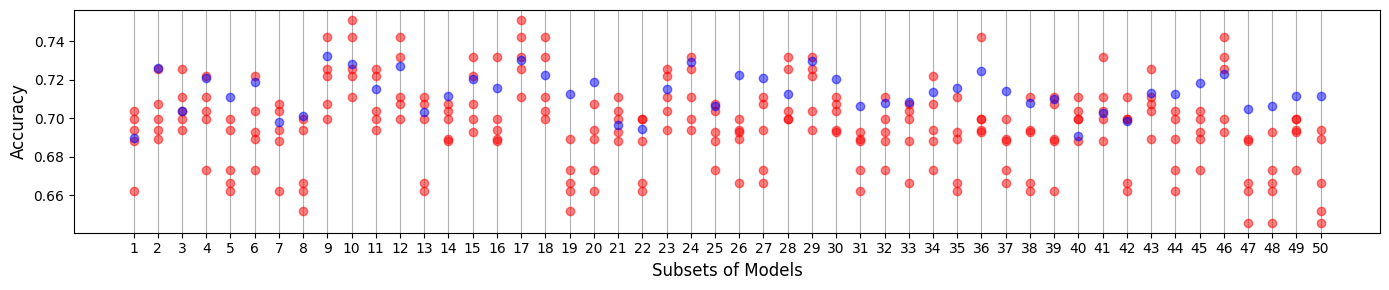

0.38 0.88


In [370]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,3))
for i in range(50):
    plt.scatter([i+1, i+1, i+1, i+1, i+1], accs_ca[i][1:6], c='red', alpha=0.5)
    plt.scatter([i+1], accs_ca[i][0], c='blue', alpha=0.5)
    # plt.scatter([i+1], np.mean(accs_ca[i][1:6]), c='red')

plt.rc('axes', axisbelow=True)
plt.grid(axis='x')
plt.plot()
plt.xlabel('Subsets of Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(np.arange(1, 51, step=1))
plt.tight_layout()
plt.savefig('accuracy_ca.png', dpi=300)
plt.show()

strong = [accs_ca[i][0] > np.max(accs_ca[i][1:6]) for i in range(50)]
weak = [accs_ca[i][0] > np.mean(accs_ca[i][1:6]) for i in range(50)]
print(np.mean(strong), np.mean(weak))

## Rank

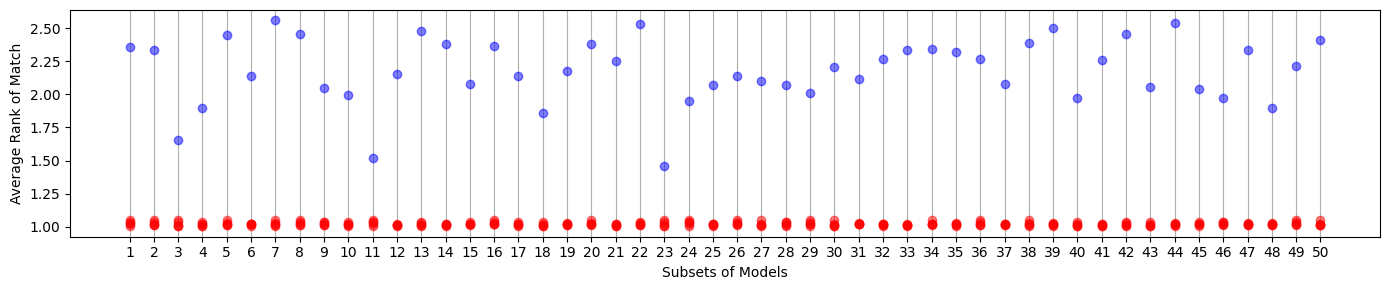

In [372]:
plt.figure(figsize=(14,3))
for i in range(50):
    plt.scatter([i+1, i+1, i+1, i+1, i+1], ranks_ca[i][1:6], c='red', alpha=0.5)
    plt.scatter([i+1], ranks_ca[i][0], c='blue', alpha=0.5)
    # plt.scatter([i+1], np.mean(ranks_ca[i][1:6]), c='red')

plt.grid(axis='x')
plt.plot()
plt.xlabel('Subsets of Models')
plt.ylabel('Average Rank of Match')
plt.xticks(np.arange(1, 51, step=1))
plt.tight_layout()
plt.savefig('rank_ca.png', dpi=300)
plt.show()

## Differential Application Access

In [379]:
# evaluate markets with differential application access

C = 5
college_caps = [1000 for _ in range(C)]
N = len(y_test)

accs_ca_diffacc = []
ranks_ca_diffacc = []

for indices_list in indices_candidates:
    sub_accs = []
    sub_ranks = []
    print(indices_list)
    approximate_values = []
    for i in indices_list:
        indices = list(itertools.combinations(range(10), 2))[i]

        model = make_pipeline(StandardScaler(), LogisticRegression())
        model.fit(X_train[:,indices], y_train)

        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])

    student_values = [np.random.uniform(size=C) for _ in range(N)]
    student_prefs = da.prefs_from_values(student_values)

    new_student_prefs = []
    num_apps = []
    for prefs in student_prefs:
        k = np.random.randint(1, C+1)
        new_student_prefs.append(prefs[:k])
        num_apps.append(k)
    student_prefs = new_student_prefs

    college_prefs = da.prefs_from_values(approximate_values)
    student_matches, college_matches = da.get_match(student_prefs, college_prefs, college_caps)

    acc = np.mean([y_test[i] for i in np.array(college_matches).flatten()])
    sub_accs.append(acc)
    sub_ranks.append(np.sum(da.student_rank_of_match(student_prefs, student_matches))/5000)

    for i in range(5):
        approximate_values = []
        
        indices = list(itertools.combinations(range(10), 2))[indices_list[i]]

        model = make_pipeline(StandardScaler(), LogisticRegression())
        model.fit(X_train[:,indices], y_train)

        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])
        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])
        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])
        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])
        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])

        student_values = [np.random.uniform(size=C) for _ in range(N)]
        student_prefs = da.prefs_from_values(student_values)

        new_student_prefs = []
        num_apps = []
        for prefs in student_prefs:
            k = np.random.randint(1, C+1)
            new_student_prefs.append(prefs[:k])
            num_apps.append(k)
        student_prefs = new_student_prefs

        college_prefs = da.prefs_from_values(approximate_values)
        student_matches, college_matches = da.get_match(student_prefs, college_prefs, college_caps)

        acc = np.mean([y_test[i] for i in np.array(college_matches).flatten()])
        sub_accs.append(acc)
        sub_ranks.append(np.sum(da.student_rank_of_match(student_prefs, student_matches))/5000)

    ranks_ca_diffacc.append(sub_ranks)
    accs_ca_diffacc.append(sub_accs)

(30, 34, 33, 1, 39)
(31, 17, 3, 33, 22)
(31, 11, 30, 3, 33)
(24, 11, 30, 34, 9)
(3, 33, 9, 19, 39)
(24, 30, 23, 22, 9)
(17, 30, 33, 1, 39)
(34, 33, 19, 39, 6)
(18, 31, 24, 17, 34)
(32, 18, 31, 24, 11)
(31, 24, 30, 34, 33)
(18, 20, 11, 17, 3)
(11, 17, 34, 19, 39)
(17, 30, 3, 22, 1)
(20, 24, 17, 34, 23)
(20, 34, 33, 22, 1)
(32, 18, 20, 31, 11)
(18, 20, 11, 30, 34)
(22, 9, 19, 39, 6)
(17, 33, 22, 9, 39)
(11, 30, 3, 23, 1)
(34, 3, 1, 19, 39)
(31, 24, 11, 30, 33)
(20, 31, 11, 34, 33)
(17, 30, 23, 1, 9)
(34, 33, 23, 22, 19)
(11, 17, 33, 9, 19)
(20, 31, 30, 34, 3)
(20, 31, 24, 30, 33)
(11, 17, 30, 33, 23)
(23, 22, 1, 9, 39)
(11, 3, 23, 1, 9)
(17, 30, 3, 1, 19)
(24, 17, 33, 1, 9)
(11, 23, 22, 19, 39)
(18, 34, 3, 33, 23)
(3, 22, 1, 9, 19)
(11, 33, 23, 19, 39)
(11, 17, 22, 1, 39)
(11, 30, 34, 3, 1)
(20, 11, 30, 3, 1)
(11, 34, 3, 19, 39)
(31, 11, 17, 30, 22)
(30, 3, 22, 9, 39)
(30, 34, 23, 22, 9)
(18, 20, 31, 34, 23)
(22, 1, 19, 39, 27)
(23, 9, 19, 39, 27)
(34, 3, 33, 23, 9)
(33, 22, 19, 6, 27)


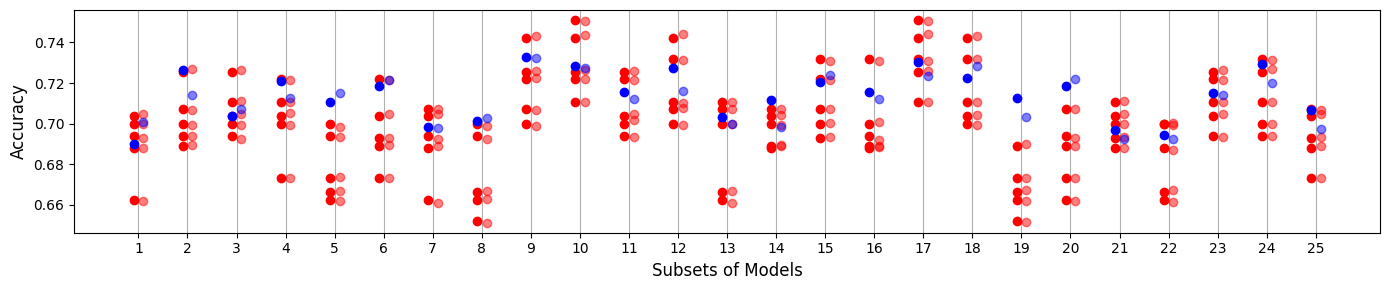

0.005792000000000002 0.0006103999999999972


In [385]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,3))
for i in range(25):
    plt.scatter([i+0.9, i+0.9, i+0.9, i+0.9, i+0.9], accs_ca[i][1:6], c='red', alpha=1)
    plt.scatter([i+1.1, i+1.1, i+1.1, i+1.1, i+1.1], accs_ca_diffacc[i][1:6], c='red', alpha=0.5)
    plt.scatter([i+1.1], accs_ca_diffacc[i][0], c='blue', alpha=0.5)
    plt.scatter([i+0.9], accs_ca[i][0], c='blue', alpha=1)

plt.rc('axes', axisbelow=True)
plt.grid(axis='x')
plt.plot()
plt.xlabel('Subsets of Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(np.arange(1, 26, step=1))
plt.tight_layout()
plt.savefig('diffacc_ca.png', dpi=300)
plt.show()

avg_poly_diff = np.mean([np.abs(accs_ca_diffacc[i][0] - accs_ca[i][0]) for i in range(50)])
avg_mono_diff = np.mean([np.mean(np.abs(np.array(accs_ca_diffacc[i][1:6]) - np.array(accs_ca[i][1:6]))) for i in range(50)])
print(avg_poly_diff, avg_mono_diff)

# ACSIncome Texas 2018

In [348]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["TX"], download=True)
features, label, group = ACSIncome.df_to_numpy(acs_data)
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.1, random_state=0)

In [349]:
print('Number of applicants:', len(y_test))
print('Number of applicants with positive label:', np.sum(y_test))

Number of applicants: 13593
Number of applicants with positive label: 5055


In [350]:
# For each pair of features, train an ML model using those features and evaluate the associated monoculture market

C = 5
college_caps = [1000 for _ in range(C)]
N = len(y_test)

monoculture_accs = []
monoculture_ranks = []
indices_subset = []
for i, indices in enumerate(itertools.combinations(range(10), 2)):
    approximate_values = []
    for indices in [indices, indices, indices, indices, indices]:

        model = make_pipeline(StandardScaler(), LogisticRegression())
        model.fit(X_train[:,indices], y_train)

        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])

    student_values = [np.random.uniform(size=C) for _ in range(N)]
    student_prefs = da.prefs_from_values(student_values)
    college_prefs = da.prefs_from_values(approximate_values)
    student_matches, college_matches = da.get_match(student_prefs, college_prefs, college_caps)

    acc = np.mean([y_test[i] for i in np.array(college_matches).flatten()])
    monoculture_accs.append(acc)
    monoculture_ranks.append(np.sum(da.student_rank_of_match(student_prefs, student_matches))/5000)

In [351]:
# Get 20 models with most accurate monoculture matchings
indices_subset = []
indices_subset_args = []
indices_subset_args = np.argsort(-np.array(monoculture_accs))[:20]
indices_subset = [list(itertools.combinations(range(10), 2))[i] for i in indices_subset_args]

In [352]:
# get 50 random subsets of 5 models with accuracies within 0.05

from random import sample
import random
random.seed(0)
indices_candidates = []
for indices_candidate in sample(list(itertools.combinations(indices_subset_args, 5), ), 1000):
    candidate_accs = [monoculture_accs[indices_candidate[i]] for i in range(5)]
    if np.max(candidate_accs) - np.min(candidate_accs) < 0.05:
        indices_candidates.append(indices_candidate)
        print(np.min(candidate_accs), np.max(candidate_accs))
indices_candidates = sample(indices_candidates, 50)


0.5696 0.6052
0.5696 0.612
0.5652 0.6042
0.5992 0.6322
0.581 0.602
0.5652 0.6066
0.5728 0.6052
0.5856 0.6322
0.5728 0.618
0.5758 0.6042
0.5696 0.6024
0.6006 0.6322
0.5728 0.612
0.5696 0.618
0.5758 0.6066
0.6018 0.6322
0.5652 0.6024
0.5728 0.612
0.5696 0.6066
0.6006 0.618
0.5652 0.6024
0.5758 0.612
0.5652 0.6024
0.5696 0.6052
0.5696 0.612
0.5856 0.6322
0.5856 0.627
0.5856 0.6322
0.5652 0.6024
0.5652 0.6052
0.5758 0.6066
0.5652 0.602
0.581 0.627
0.5758 0.6024
0.581 0.612
0.5696 0.6052
0.5696 0.612
0.5992 0.6052
0.5758 0.6066
0.5696 0.618
0.581 0.618
0.6006 0.6052
0.5652 0.6052
0.6052 0.6322
0.5652 0.612
0.5696 0.612
0.5652 0.6042
0.5652 0.6024
0.6006 0.6322
0.5728 0.6066
0.5696 0.6066
0.5856 0.6322
0.5758 0.6042
0.5696 0.6018
0.5856 0.6322
0.6006 0.612
0.6006 0.6322
0.5696 0.6066
0.5728 0.602
0.581 0.618
0.5728 0.618
0.581 0.627
0.581 0.6066
0.6006 0.618
0.6006 0.6322
0.5696 0.6066
0.5696 0.618
0.5728 0.618
0.5728 0.612
0.5652 0.6042
0.5758 0.602
0.5652 0.6052
0.581 0.6024
0.5696 0.612
0

In [353]:
# evaluate polyculture markets

C = 5
college_caps = [1000 for _ in range(C)]
N = len(y_test)

accs_tx = []
ranks_tx = []

for indices_list in indices_candidates:
    sub_accs = []
    sub_ranks = []
    print(indices_list)
    approximate_values = []
    for i in indices_list:
        indices = list(itertools.combinations(range(10), 2))[i]

        model = make_pipeline(StandardScaler(), LogisticRegression())
        model.fit(X_train[:,indices], y_train)

        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])

    student_values = [np.random.uniform(size=C) for _ in range(N)]
    student_prefs = da.prefs_from_values(student_values)
    college_prefs = da.prefs_from_values(approximate_values)
    student_matches, college_matches = da.get_match(student_prefs, college_prefs, college_caps)

    acc = np.mean([y_test[i] for i in np.array(college_matches).flatten()])
    sub_accs.append(acc)
    sub_ranks.append(np.sum(da.student_rank_of_match(student_prefs, student_matches))/5000)

    for i in range(5):
        acc = monoculture_accs[indices_list[i]]
        sub_accs.append(acc)
        sub_ranks.append(monoculture_ranks[indices_list[i]])

    ranks_tx.append(sub_ranks)
    accs_tx.append(sub_accs)



(32, 11, 9, 30, 39)
(1, 23, 11, 30, 3)
(18, 32, 20, 23, 31)
(20, 23, 22, 39, 6)
(20, 9, 39, 3, 27)
(23, 34, 17, 30, 3)
(11, 34, 17, 39, 14)
(9, 19, 17, 30, 14)
(31, 17, 3, 27, 14)
(1, 31, 17, 39, 36)
(18, 32, 17, 30, 39)
(9, 19, 22, 17, 3)
(31, 22, 30, 39, 3)
(23, 31, 17, 6, 27)
(32, 9, 22, 17, 39)
(1, 20, 30, 3, 36)
(34, 19, 3, 36, 27)
(19, 30, 39, 3, 36)
(23, 19, 22, 3, 36)
(20, 39, 3, 36, 27)
(23, 31, 39, 3, 27)
(11, 34, 9, 27, 14)
(20, 31, 11, 3, 36)
(1, 20, 23, 19, 6)
(20, 31, 34, 19, 22)
(1, 11, 3, 36, 27)
(23, 19, 30, 39, 27)
(23, 34, 19, 17, 27)
(23, 11, 9, 19, 36)
(31, 11, 34, 19, 36)
(20, 31, 11, 39, 14)
(19, 17, 39, 36, 6)
(20, 23, 3, 36, 6)
(18, 1, 20, 11, 17)
(23, 34, 22, 30, 3)
(23, 22, 17, 3, 14)
(20, 23, 31, 34, 27)
(32, 23, 31, 34, 3)
(1, 20, 23, 11, 39)
(32, 20, 23, 11, 30)
(23, 31, 9, 30, 14)
(20, 9, 3, 6, 14)
(34, 9, 19, 22, 3)
(11, 34, 19, 30, 39)
(20, 11, 17, 3, 14)
(19, 22, 3, 36, 6)
(19, 22, 3, 6, 27)
(31, 34, 17, 30, 27)
(18, 20, 11, 22, 30)
(18, 11, 9, 22, 30)

## Accuracy

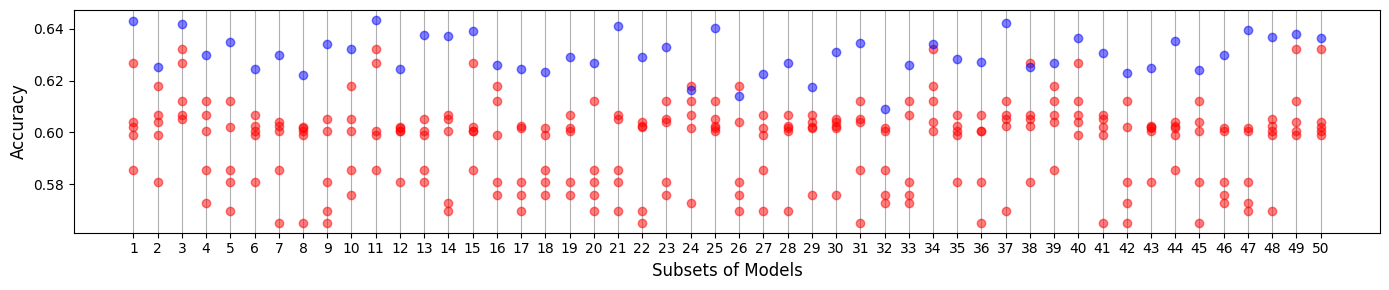

0.94 1.0


In [366]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,3))
for i in range(50):
    plt.scatter([i+1, i+1, i+1, i+1, i+1], accs_tx[i][1:6], c='red', alpha=0.5)
    plt.scatter([i+1], accs_tx[i][0], c='blue', alpha=0.5)
    # plt.scatter([i+1], np.mean(accs_tx[i][1:6]), c='red')

plt.rc('axes', axisbelow=True)
plt.grid(axis='x')
plt.plot()
plt.xlabel('Subsets of Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(np.arange(1, 51, step=1))
plt.tight_layout()
plt.savefig('accuracy_tx.png', dpi=300)
plt.show()

strong = [accs_tx[i][0] > np.max(accs_tx[i][1:6]) for i in range(50)]
weak = [accs_tx[i][0] > np.mean(accs_tx[i][1:6]) for i in range(50)]
print(np.mean(strong), np.mean(weak))

## Rank

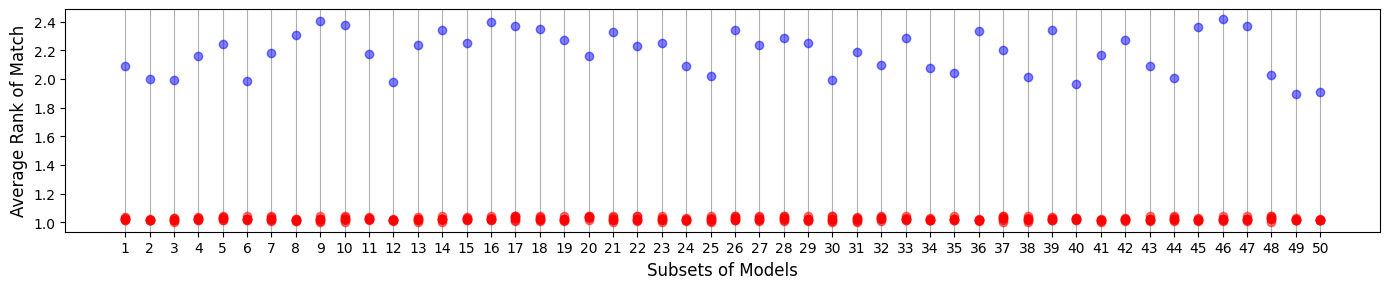

In [367]:
plt.figure(figsize=(14,3))
for i in range(50):
    plt.scatter([i+1, i+1, i+1, i+1, i+1], ranks_tx[i][1:6], c='red', alpha=0.5)
    plt.scatter([i+1], ranks_tx[i][0], c='blue', alpha=0.5)
    plt.scatter([i+1], np.mean(ranks_tx[i][1:6]), c='red')

plt.grid(axis='x')
plt.plot()
plt.xlabel('Subsets of Models', fontsize=12)
plt.ylabel('Average Rank of Match', fontsize=12)
plt.xticks(np.arange(1, 51, step=1))
plt.tight_layout()
plt.savefig('rank_tx.png', dpi=300)
plt.show()

## Differential Application Access

In [358]:
# evaluate markets with differential application access

C = 5
college_caps = [1000 for _ in range(C)]
N = len(y_test)

accs_tx_diffacc = []
ranks_tx_diffacc = []

for indices_list in indices_candidates:
    sub_accs = []
    sub_ranks = []
    print(indices_list)
    approximate_values = []
    for i in indices_list:
        indices = list(itertools.combinations(range(10), 2))[i]

        model = make_pipeline(StandardScaler(), LogisticRegression())
        model.fit(X_train[:,indices], y_train)

        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])

    student_values = [np.random.uniform(size=C) for _ in range(N)]
    student_prefs = da.prefs_from_values(student_values)

    new_student_prefs = []
    num_apps = []
    for prefs in student_prefs:
        k = np.random.randint(1, C+1)
        new_student_prefs.append(prefs[:k])
        num_apps.append(k)
    student_prefs = new_student_prefs

    college_prefs = da.prefs_from_values(approximate_values)
    student_matches, college_matches = da.get_match(student_prefs, college_prefs, college_caps)

    acc = np.mean([y_test[i] for i in np.array(college_matches).flatten()])
    sub_accs.append(acc)
    sub_ranks.append(np.sum(da.student_rank_of_match(student_prefs, student_matches))/5000)

    for i in range(5):
        approximate_values = []
        
        indices = list(itertools.combinations(range(10), 2))[indices_list[i]]

        model = make_pipeline(StandardScaler(), LogisticRegression())
        model.fit(X_train[:,indices], y_train)

        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])
        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])
        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])
        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])
        approximate_values.append(model.predict_proba(X_test[:,indices])[:, 1])

        student_values = [np.random.uniform(size=C) for _ in range(N)]
        student_prefs = da.prefs_from_values(student_values)

        new_student_prefs = []
        num_apps = []
        for prefs in student_prefs:
            k = np.random.randint(1, C+1)
            new_student_prefs.append(prefs[:k])
            num_apps.append(k)
        student_prefs = new_student_prefs

        college_prefs = da.prefs_from_values(approximate_values)
        student_matches, college_matches = da.get_match(student_prefs, college_prefs, college_caps)

        acc = np.mean([y_test[i] for i in np.array(college_matches).flatten()])
        sub_accs.append(acc)
        sub_ranks.append(np.sum(da.student_rank_of_match(student_prefs, student_matches))/5000)

    ranks_tx_diffacc.append(sub_ranks)
    accs_tx_diffacc.append(sub_accs)



(32, 11, 9, 30, 39)
(1, 23, 11, 30, 3)
(18, 32, 20, 23, 31)
(20, 23, 22, 39, 6)
(20, 9, 39, 3, 27)
(23, 34, 17, 30, 3)
(11, 34, 17, 39, 14)
(9, 19, 17, 30, 14)
(31, 17, 3, 27, 14)
(1, 31, 17, 39, 36)
(18, 32, 17, 30, 39)
(9, 19, 22, 17, 3)
(31, 22, 30, 39, 3)
(23, 31, 17, 6, 27)
(32, 9, 22, 17, 39)
(1, 20, 30, 3, 36)
(34, 19, 3, 36, 27)
(19, 30, 39, 3, 36)
(23, 19, 22, 3, 36)
(20, 39, 3, 36, 27)
(23, 31, 39, 3, 27)
(11, 34, 9, 27, 14)
(20, 31, 11, 3, 36)
(1, 20, 23, 19, 6)
(20, 31, 34, 19, 22)
(1, 11, 3, 36, 27)
(23, 19, 30, 39, 27)
(23, 34, 19, 17, 27)
(23, 11, 9, 19, 36)
(31, 11, 34, 19, 36)
(20, 31, 11, 39, 14)
(19, 17, 39, 36, 6)
(20, 23, 3, 36, 6)
(18, 1, 20, 11, 17)
(23, 34, 22, 30, 3)
(23, 22, 17, 3, 14)
(20, 23, 31, 34, 27)
(32, 23, 31, 34, 3)
(1, 20, 23, 11, 39)
(32, 20, 23, 11, 30)
(23, 31, 9, 30, 14)
(20, 9, 3, 6, 14)
(34, 9, 19, 22, 3)
(11, 34, 19, 30, 39)
(20, 11, 17, 3, 14)
(19, 22, 3, 36, 6)
(19, 22, 3, 6, 27)
(31, 34, 17, 30, 27)
(18, 20, 11, 22, 30)
(18, 11, 9, 22, 30)

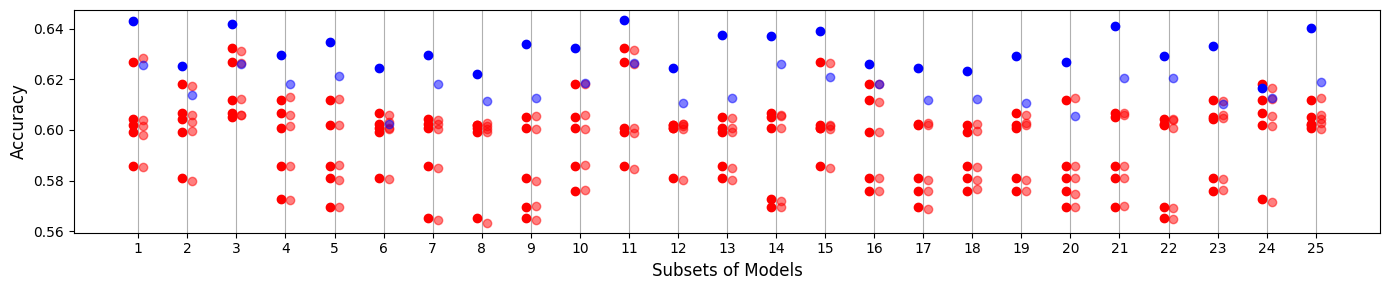

0.015355999999999998 0.0005560000000000001


In [386]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,3))
for i in range(25):
    plt.scatter([i+0.9, i+0.9, i+0.9, i+0.9, i+0.9], accs_tx[i][1:6], c='red', alpha=1)
    plt.scatter([i+1.1, i+1.1, i+1.1, i+1.1, i+1.1], accs_tx_diffacc[i][1:6], c='red', alpha=0.5)
    plt.scatter([i+1.1], accs_tx_diffacc[i][0], c='blue', alpha=0.5)
    plt.scatter([i+0.9], accs_tx[i][0], c='blue', alpha=1)

plt.rc('axes', axisbelow=True)
plt.grid(axis='x')
plt.plot()
plt.xlabel('Subsets of Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(np.arange(1, 26, step=1))
plt.tight_layout()
plt.savefig('diffacc_tx.png', dpi=300)
plt.show()

avg_poly_diff = np.mean([np.abs(accs_tx_diffacc[i][0] - accs_tx[i][0]) for i in range(50)])
avg_mono_diff = np.mean([np.mean(np.abs(np.array(accs_tx_diffacc[i][1:6]) - np.array(accs_tx[i][1:6]))) for i in range(50)])
print(avg_poly_diff, avg_mono_diff)